In [ ]:
import os
import glob
import cv2
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore', category=UserWarning)

class VQAnalyzer:

    def __init__(self, n_clusters=64, patch_size=16):
       
        self.n_clusters = n_clusters
        self.patch_size = patch_size
        self.kmeans = MiniBatchKMeans(n_clusters=self.n_clusters, random_state=42, batch_size=256)
        self.codebook = None

    def _extract_patches(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None: return []
        
        h, w = img.shape
        patches = []
        for i in range(0, h - self.patch_size, self.patch_size):
            for j in range(0, w - self.patch_size, self.patch_size):
                patch = img[i:i+self.patch_size, j:j+self.patch_size]
                patches.append(patch.flatten())
        return patches

    def fit(self, all_image_paths):
        print(f"--- 코드북 학습 시작 (K={self.n_clusters}) ---")
        all_patches = []
        for img_path in all_image_paths:
            all_patches.extend(self._extract_patches(img_path))
        
        if not all_patches:
            print("[에러] 이미지를 처리할 수 없어 코드북 학습 실패.")
            return

        self.kmeans.fit(np.array(all_patches))
        self.codebook = self.kmeans.cluster_centers_
        print("--- 코드북 학습 완료 ---")

    def transform_to_bovw(self, img_path):
        if self.codebook is None:
            raise Exception("코드북이 학습되지 않았습니다. 먼저 .fit() 메서드를 실행하세요.")
            
        patches = self._extract_patches(img_path)
        if not patches:
            return np.zeros(self.n_clusters)
            
        visual_words = self.kmeans.predict(np.array(patches))
        
        histogram, _ = np.histogram(visual_words, bins=np.arange(self.n_clusters + 1))
        
        histogram = histogram.astype(float)
        if np.sum(histogram) > 0:
            histogram /= np.linalg.norm(histogram)
            
        return histogram

    def visualize_codebook(self):
        """학습된 코드북(시각 단어집)을 시각화한다."""
        if self.codebook is None:
            print("코드북이 학습되지 않았습니다.")
            return

        print("\n--- 학습된 코드북(시각 단어집) 시각화 ---")
        grid_size = int(np.ceil(np.sqrt(self.n_clusters)))
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
        fig.suptitle(f'Learned Visual Vocabulary (K={self.n_clusters})', fontsize=16)

        for i, ax in enumerate(axes.flat):
            if i < len(self.codebook):
                visual_word = self.codebook[i].reshape(self.patch_size, self.patch_size)
                ax.imshow(visual_word, cmap='gray')
                ax.set_title(f'Word {i}')
            ax.axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

if __name__ == '__main__':
    v1_dir = './first_upload'
    v2_dir = './second_upload'

    all_files = glob.glob(os.path.join(v1_dir, '*.png')) + glob.glob(os.path.join(v2_dir, '*.png'))

    vq_analyzer = VQAnalyzer(n_clusters=64) 
    vq_analyzer.fit(all_files)
    
    vq_analyzer.visualize_codebook()

    v1_files = sorted(glob.glob(os.path.join(v1_dir, '*.png')))
    v2_files = sorted(glob.glob(os.path.join(v2_dir, '*.png')))

    v1_bovw = [vq_analyzer.transform_to_bovw(f) for f in v1_files]
    v2_bovw = [vq_analyzer.transform_to_bovw(f) for f in v2_files]

    similarity_matrix = cosine_similarity(v2_bovw, v1_bovw)

    print("\n--- VQ 기반 매칭 결과 ---")
    threshold = 0.95 
    for i, scores in enumerate(similarity_matrix):
        best_match_idx = np.argmax(scores)
        score = scores[best_match_idx]
        
        print(f"v2 '{os.path.basename(v2_files[i])[:10]}...' vs v1 '{os.path.basename(v1_files[best_match_idx])[:10]}...' -> Score: {score:.4f}")




--- 학습된 코드북(시각 단어집) 시각화 ---


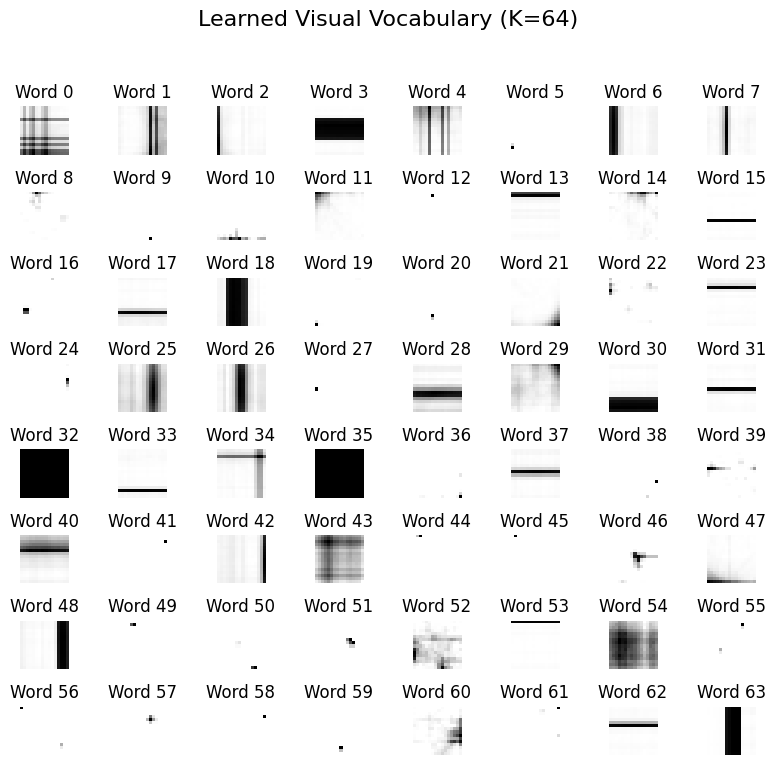

In [ ]:
import matplotlib.pyplot as plt

print("\n--- 학습된 코드북(시각 단어집) 시각화 ---")

codebook = vq_analyzer.codebook
patch_size = vq_analyzer.patch_size 
n_clusters = vq_analyzer.n_clusters
grid_size = int(np.sqrt(n_clusters))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
fig.suptitle(f'Learned Visual Vocabulary (K={n_clusters})', fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(codebook):
        visual_word = codebook[i].reshape(patch_size, patch_size)
        
        ax.imshow(visual_word, cmap='gray')
        ax.set_title(f'Word {i}')
    
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()